In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from xgboost import plot_importance

from matplotlib import pyplot
%matplotlib inline
sns.set(color_codes=True)
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
wine=pd.read_csv('winewhite_with_bands.csv')

In [3]:
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,fixed acidity_band,volatile acidity_band,citric acid_band,residual sugar_band,chlorides_band,free sulfur dioxide_band,total sulfur dioxide_band,density_band,pH_band,sulphates_band,alcohol_band,badtag
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,5,5,6,9,5,7,7,9,0,3,0,0.0
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,2,6,5,2,7,0,4,5,7,5,2,0.0
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,9,5,7,5,7,4,1,6,7,3,4,0.0
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,6,3,4,6,8,7,8,6,5,2,3,0.0
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,6,3,4,6,8,7,8,6,5,2,3,0.0


In [4]:
wine.shape

(4898, 24)

In [5]:
var_band=[i for i in wine.columns.values if i.endswith('_band')]

In [6]:
orig_ban = [i for i in wine.columns.values if i not in var_band]

In [7]:
orig_ban

['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol',
 'quality',
 'badtag']

In [8]:
var_band

['fixed acidity_band',
 'volatile acidity_band',
 'citric acid_band',
 'residual sugar_band',
 'chlorides_band',
 'free sulfur dioxide_band',
 'total sulfur dioxide_band',
 'density_band',
 'pH_band',
 'sulphates_band',
 'alcohol_band']

# Calculation of Weight of evidence

In [9]:
def calculate_woe(input_df,badtag,woe_varlist):
    total_pop=input_df.shape[0]
    bads=input_df.groupby(badtag)[badtag].sum()
    goods=total_pop-bads
    
    return[find_woe_variable(input_df,var,total_pop,bads,goods) for var in woe_variable_list]

In [10]:
def woe_feature(x,y,event):
    #X: numpy array of first feature
    #y:numpy array of target variable
    
    ev_total,no_ev_total=event_count(y,event)
    x_lab=np.unique(x)
    woe_dict={}
    
    for x1 in x_lab:
        y1=y[np.where(x==x1)[0]]
        ev_count,no_ev_count=event_count(y1,event)
        rate_event=1.0*ev_count/ev_total
        rate_non_event=1.0*no_ev_count/ev_total
        
        if rate_event==0:
            rate_event=-50
        elif rate_non_event==0:
            rate_non_event=50
        else:
            woe1=math.log(rate_event/rate_non_event)
            
        woe_dict[x1]=woe1
        
    return woe_dict

def event_count(a,event=1):
    event_count=(a==event).sum()
    non_event_count=a.shape[-1]-event_count
    return event_count,non_event_count

def find_append_woe(df,column_name,target):
   
    print('processing',column_name)

    woe_dict_1=woe_feature(df[column_name],df[target].values,1)
    woe_array=np.array([woe_dict_1])
    new_col_df=pd.DataFrame()
    new_col_df[column_name]=df[column_name]
    new_col_df[column_name +'_woe']=new_col_df[column_name].replace(woe_array[0])
    del(new_col_df[column_name])
    df=pd.concat([df,new_col_df],axis=1)
    return df

def loop_woe(df,cols):
    target='badtag'
    
    for col in cols:
        df=find_append_woe(df,col,target)
        
    return df


In [11]:

df=loop_woe(wine,var_band)

processing fixed acidity_band
processing volatile acidity_band
processing citric acid_band
processing residual sugar_band
processing chlorides_band
processing free sulfur dioxide_band
processing total sulfur dioxide_band
processing density_band
processing pH_band
processing sulphates_band
processing alcohol_band


# Model for wine

In [12]:
var_to_train=[i for i in df.columns.values if i.endswith('_band_woe')]

In [13]:
var_to_train

['fixed acidity_band_woe',
 'volatile acidity_band_woe',
 'citric acid_band_woe',
 'residual sugar_band_woe',
 'chlorides_band_woe',
 'free sulfur dioxide_band_woe',
 'total sulfur dioxide_band_woe',
 'density_band_woe',
 'pH_band_woe',
 'sulphates_band_woe',
 'alcohol_band_woe']

In [14]:
orig_var = [i for i in orig_ban if i not in ['badtag','quality']]

In [15]:
orig_var

['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol']

In [16]:
woe_df = df[var_to_train]
orig_df = df[orig_var]
y_woe = df['badtag']
y_orig_df = df['badtag']

In [17]:

X_train, X_test, y_train, y_test = train_test_split(
    woe_df, y_woe, test_size=0.35, random_state=20)   

In [18]:

orig_train, orig_test, y_train_or, y_test_or = train_test_split(
    orig_df,y_orig_df, test_size=0.35, random_state=20)   

Here we made two train and test set one is X_train which contain weight of evidence variables and the one which do not contain any modified features,just the given features

In [19]:
orig_train.head(2)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
2359,6.0,0.495,0.27,5.0,0.157,17.0,129.0,0.99396,3.03,0.36,9.3
2584,6.8,0.180,0.30,12.8,0.062,19.0,171.0,0.99808,3.00,0.52,9.0


## Logistic Regression Model

In [20]:
lr=LogisticRegression()
lr.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [21]:
lr_orig = LogisticRegression()
lr_orig.fit(orig_train,y_train_or)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [22]:
pred=lr.predict(X_test)
pred_orig = lr_orig.predict(orig_test)

In [23]:
lr.score(X_train, y_train)

0.7640590637763116

In [24]:
lr.score(X_test,y_test)

0.7667638483965015

The almost similar accuracy ensure that our model is giving a good validation accuracy.

In [25]:
lr_orig.score(orig_train,y_train_or)

0.7461514294690543

In [26]:
lr_orig.score(orig_test,y_test_or)

0.7504373177842566

The accuracy from the original features is way less than weight of evidences features.Now we will check whether our model is stabel or not by checking classification reports and cross val scores


In [27]:
from sklearn import metrics
print(metrics.confusion_matrix(y_test, pred))
print(metrics.classification_report(y_test, pred))

[[987 144]
 [256 328]]
             precision    recall  f1-score   support

        0.0       0.79      0.87      0.83      1131
        1.0       0.69      0.56      0.62       584

avg / total       0.76      0.77      0.76      1715



In [28]:
from sklearn import metrics
print(metrics.confusion_matrix(y_test, pred_orig))
print(metrics.classification_report(y_test, pred_orig))

[[1011  120]
 [ 308  276]]
             precision    recall  f1-score   support

        0.0       0.77      0.89      0.83      1131
        1.0       0.70      0.47      0.56       584

avg / total       0.74      0.75      0.74      1715



The classification reports also looks good with respect to the original feature classification report.

In [29]:
tn, fp, fn, tp = metrics.confusion_matrix(y_test, pred).ravel()
print(tn,fp,fn,tp)

987 144 256 328


In [30]:
tn, fp, fn, tp = metrics.confusion_matrix(y_test, pred_orig).ravel()
print(tn,fp,fn,tp)

1011 120 308 276


Our model with Weight of evidence features is able to detect more true negatives than the one with original features

In [31]:
probs = lr.predict_proba(X_test)

In [32]:
from sklearn.cross_validation import cross_val_score
from sklearn import cross_validation
# evaluate the model using 10-fold cross-validation
scores = cross_val_score(LogisticRegression(), X_train, y_train, scoring='accuracy', cv=10)

print(scores)
print(scores.mean())

[0.76802508 0.77429467 0.79310345 0.75548589 0.73981191 0.74294671
 0.71698113 0.77287066 0.76025237 0.76971609]
0.7593487960393459


Our model's cross validation results are also good ensuring stability in our model. 

## XgBoost Model

In [33]:
model=XGBClassifier()
model.fit(X_train,y_train)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [34]:
y_pred=model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 77.90%


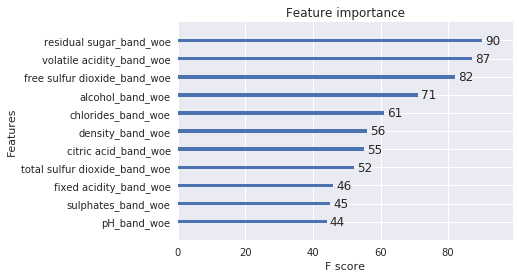

In [35]:
plot_importance(model)

In [36]:
tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()
print(tn,fp,fn,tp)

1006 125 254 330


In [37]:
from sklearn import metrics
print(metrics.confusion_matrix(y_test, pred_orig))
print(metrics.classification_report(y_test, pred_orig))

[[1011  120]
 [ 308  276]]
             precision    recall  f1-score   support

        0.0       0.77      0.89      0.83      1131
        1.0       0.70      0.47      0.56       584

avg / total       0.74      0.75      0.74      1715



In [38]:
from sklearn.cross_validation import cross_val_score
from sklearn import cross_validation
# evaluate the model using 10-fold cross-validation
scores = cross_val_score(XGBClassifier(), X_train, y_train, scoring='accuracy', cv=10)

print(scores)
print(scores.mean())

[0.75862069 0.80564263 0.76489028 0.77115987 0.7523511  0.76489028
 0.74528302 0.79495268 0.79810726 0.78864353]
0.7744541347833639


The XG boost classifier is not so stable as the logistic regression on Weight of evidence variables.Since the cross validation accuracy varies a lot.This model would not be considered as a stable model 

In [39]:
model_orig=XGBClassifier()
model_orig.fit(orig_train,y_train_or)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [40]:
y_pred_or=model_orig.predict(orig_test)
accuracy = accuracy_score(y_test_or, y_pred_or)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 78.43%


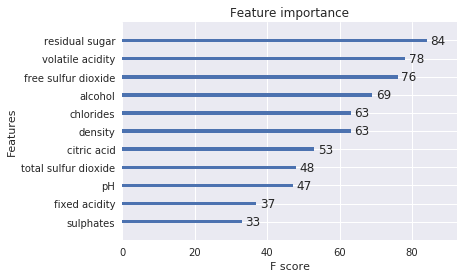

In [41]:
plot_importance(model_orig)

In [42]:
from sklearn.cross_validation import cross_val_score
from sklearn import cross_validation
# evaluate the model using 10-fold cross-validation
scores2 = cross_val_score(XGBClassifier(), orig_train, y_train_or, scoring='accuracy', cv=10)

print(scores2)
print(scores2.mean())

[0.76489028 0.80877743 0.78996865 0.78996865 0.76802508 0.77742947
 0.74842767 0.78548896 0.78864353 0.78548896]
0.7807108685188602


# Naive bayes Classifier

In [43]:
gnb = GaussianNB()

In [44]:
y_pred = gnb.fit(X_train,y_train).predict(X_test)

In [45]:
from sklearn.cross_validation import cross_val_score
from sklearn import cross_validation
# evaluate the model using 10-fold cross-validation
scores = cross_val_score(GaussianNB(), X_train, y_train, scoring='accuracy', cv=10)

print(scores)
print(scores.mean())

[0.72100313 0.6677116  0.72413793 0.69905956 0.67711599 0.70219436
 0.67610063 0.72870662 0.70031546 0.68454259]
0.698088786823345


In [46]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 71.55%


In [47]:
from sklearn.cross_validation import cross_val_score
from sklearn import cross_validation
# evaluate the model using 10-fold cross-validation
scores = cross_val_score(GaussianNB(), orig_train, y_train_or, scoring='accuracy', cv=10)

print(scores)
print(scores.mean())

[0.73667712 0.69278997 0.71473354 0.68652038 0.68965517 0.71786834
 0.67610063 0.72870662 0.70662461 0.70662461]
0.7056300978999546


In [48]:
y_pred_orig = gnb.fit(orig_train,y_train_or).predict(orig_test)
accuracy = accuracy_score(y_test_or, y_pred_orig)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 71.37%


We can see from above results that a naive base classifier is not good for our problem statement.The cross validation scores as well accuracy are not upto mark as compared to logistic regression model and XGboost model